In [1]:
from diffusers import StableDiffusionXLControlNetInpaintPipeline, ControlNetModel
from rembg import remove
from PIL import Image
import torch
from ip_adapter import IPAdapterXL
from ip_adapter.utils import register_cross_attention_hook, get_net_attn_map, attnmaps2images
from PIL import Image, ImageChops
import numpy as np

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [2]:
base_model_path = "stabilityai/stable-diffusion-xl-base-1.0"
image_encoder_path = "models/image_encoder"
ip_ckpt = "sdxl_models/ip-adapter_sdxl_vit-h.bin"
controlnet_path = "diffusers/controlnet-depth-sdxl-1.0"
device = "cuda"

In [3]:
torch.cuda.empty_cache()

# load SDXL pipeline
controlnet = ControlNetModel.from_pretrained(controlnet_path, variant="fp16", use_safetensors=True, torch_dtype=torch.float16).to(device)
pipe = StableDiffusionXLControlNetInpaintPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    use_safetensors=True,
    torch_dtype=torch.float16,
    add_watermarker=False,
).to(device)
pipe.unet = register_cross_attention_hook(pipe.unet)

ip_model = IPAdapterXL(pipe, image_encoder_path, ip_ckpt, device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:

obj = 'pumpkin'
texture = 'cup_glaze'
target_image_path = 'demo_assets/input_imgs/' + obj + '.png'  # Replace with your image path
target_image = Image.open(target_image_path).convert('RGB')
rm_bg = remove(target_image)
# output.save(output_path)
target_mask = rm_bg.convert("RGB").point(lambda x: 0 if x < 1 else 255).convert('L').convert('RGB')# Convert mask to grayscale

# Ensure mask is the same size as image

# mask = ImageChops.invert(mask)
# Generate random noise for the size of the image
noise = np.random.randint(0, 256, target_image.size + (3,), dtype=np.uint8)
noise_image = Image.fromarray(noise)
mask_target_img = ImageChops.lighter(target_image, target_mask)
invert_target_mask = ImageChops.invert(target_mask)



In [5]:
from PIL import ImageEnhance
gray_target_image = target_image.convert('L').convert('RGB')
gray_target_image = ImageEnhance.Brightness(gray_target_image)

# Adjust brightness
# The factor 1.0 means original brightness, greater than 1.0 makes the image brighter. Adjust this if the image is too dim
factor = 1.0  # Try adjusting this to get the desired brightness

gray_target_image = gray_target_image.enhance(factor)
grayscale_img = ImageChops.darker(gray_target_image, target_mask)
img_black_mask = ImageChops.darker(target_image, invert_target_mask)
grayscale_init_img = ImageChops.lighter(img_black_mask, grayscale_img)
init_img = grayscale_init_img

ip_image = Image.open("demo_assets/material_exemplars/" + texture + ".png")

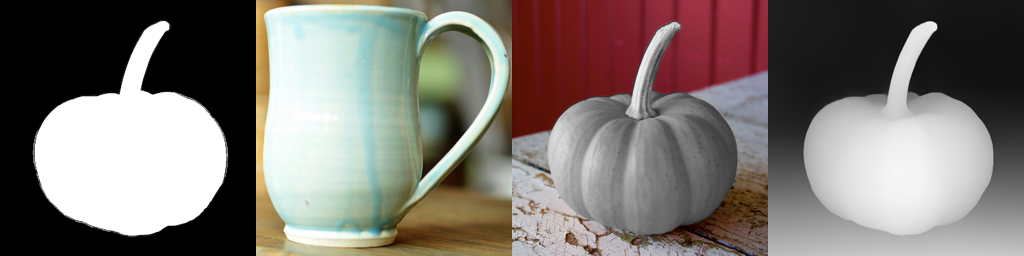

In [6]:

np_image = np.array(Image.open('demo_assets/depths/' + obj + '.png'))
np_image = (np_image / 256).astype('uint8')

depth_map = Image.fromarray(np_image).resize((1024,1024))

init_img = init_img.resize((1024,1024))
mask = target_mask.resize((1024, 1024))
grid = image_grid([target_mask.resize((256, 256)), ip_image.resize((256, 256)), init_img.resize((256, 256)), depth_map.resize((256, 256))], 1, 4)

# Visualize each input individually
grid

best quality, high quality


  0%|          | 0/29 [00:00<?, ?it/s]

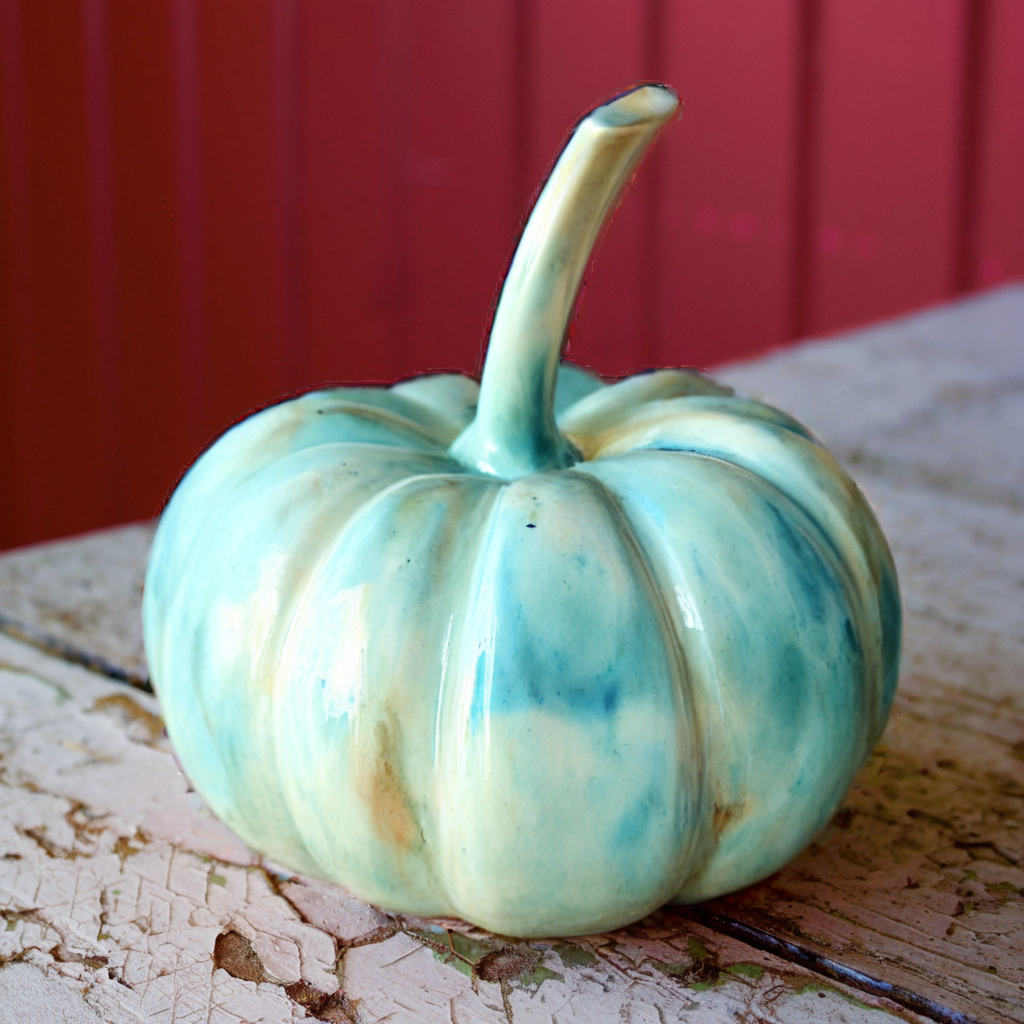

In [8]:
num_samples = 1
images = ip_model.generate(pil_image=ip_image, image=init_img, control_image=depth_map, mask_image=mask, controlnet_conditioning_scale=0.9, num_samples=num_samples, num_inference_steps=30, seed=42)
images[0].show()